In [2]:
import pandas as pd

#Load the training data
training_data_path = 'sprint3_transactions.csv'
train_df = pd.read_csv(training_data_path)

#Preview the datafframe
train_df.head(), train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235788 entries, 0 to 235787
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   competition_id  235788 non-null  int64  
 1   Amount          235788 non-null  float64
 2   V1              235755 non-null  float64
 3   V2              235769 non-null  float64
 4   V3              235761 non-null  float64
 5   V4              235773 non-null  float64
 6   V5              235745 non-null  float64
 7   V6              235755 non-null  float64
 8   V7              235775 non-null  float64
 9   V8              235747 non-null  float64
 10  V9              235770 non-null  float64
 11  V10             235782 non-null  float64
 12  V11             235762 non-null  float64
 13  V12             235779 non-null  float64
 14  V13             235769 non-null  float64
 15  V14             235785 non-null  float64
 16  V15             235773 non-null  float64
 17  V16       

(   competition_id        Amount        V1        V2        V3        V4  \
 0          200001   5384.439941  1.073515 -0.357867  0.403438 -0.489846   
 1          200002  17982.099610  0.115433 -0.126228  1.760780  0.465503   
 2          200003   6901.490234 -0.134323 -0.409743  1.272522 -0.338456   
 3          200004  14278.969730 -0.538880 -1.353725  0.316332 -0.270522   
 4          200005    210.350006  0.975284 -0.338808  0.802451 -0.201451   
 
          V5        V6        V7        V8  ...       V20       V21       V22  \
 0  0.350531  0.427065  0.413984 -0.145682  ... -0.211017 -0.232020 -0.865567   
 1  0.338733  0.655035  0.492372 -0.093471  ... -0.419567  0.015181  0.808545   
 2  0.973651  0.591710  0.462300 -0.128050  ...  0.405960 -0.148264 -0.494632   
 3 -0.038734  1.534834  2.479669 -0.156215  ...  1.870997  0.136272 -0.175280   
 4  0.110070  0.066379  0.442581 -0.168338  ... -0.288194 -0.097900  0.000855   
 
         V23       V24       V25       V26       V27  

In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np



#Put in missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
train_df_imputed = pd.DataFrame(imputer.fit_transform(train_df.drop(columns=['competition_id', 'Class'])),
                                columns=train_df.drop(columns=['competition_id', 'Class']).columns)

#Normalize the amount column
scaler = StandardScaler()
train_df_imputed['NormalizedAmount'] = scaler.fit_transform(train_df_imputed[['Amount']])
train_df_imputed.drop(columns=['Amount'], inplace=True)

#Add the class column back
train_df_imputed['Class'] = train_df['Class']

#Split the data into features and target
X = train_df_imputed.drop(columns=['Class'])
y = train_df_imputed['Class']

#Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Apply SMOTE cause of class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#Train the Random Forest
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced')
rf_classifier.fit(X_train_smote, y_train_smote)

#Predict class probabilities rather than classes directly
y_prob = rf_classifier.predict_proba(X_val)[:, 1] 

#Choose a new threshold
new_threshold = 0.6  

#Apply the new threshold to determine class predictions
y_pred_adjusted = (y_prob >= new_threshold).astype(int)

#Evaluate the model 
confusion_mat_adjusted = confusion_matrix(y_val, y_pred_adjusted)
classification_rep_adjusted = classification_report(y_val, y_pred_adjusted)

print("Confusion Matrix (Adjusted):")
print(confusion_mat_adjusted)
print("\nClassification Report (Adjusted):")
print(classification_rep_adjusted)

Confusion Matrix (Adjusted):
[[46574     9]
 [   28   547]]

Classification Report (Adjusted):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46583
           1       0.98      0.95      0.97       575

    accuracy                           1.00     47158
   macro avg       0.99      0.98      0.98     47158
weighted avg       1.00      1.00      1.00     47158



In [4]:
#SMOTE and Class Weight balance

#Just SMOTE
#array([[46572,    11],
       #[   20,   555]])

#Stratify=y
#array([[46576,     7],
       #[   56,   519]])

In [7]:
#Evaluate the model
confusion_mat = confusion_matrix(y_val, y_pred_adjusted)
classification_rep = classification_report(y_val, y_pred_adjusted)

confusion_mat

array([[46574,     9],
       [   28,   547]])

In [8]:
#SMOTE and Classw weight balanced

#Just SMOTE
#Class
#0    0.987811
#1    0.012189

#stratify=y
#Class
#0    0.987811
#1    0.012189

In [9]:
#Show me the proportion of each class in the target
class_distribution = y.value_counts(normalize=True)  
print(class_distribution)

Class
0    0.987811
1    0.012189
Name: proportion, dtype: float64


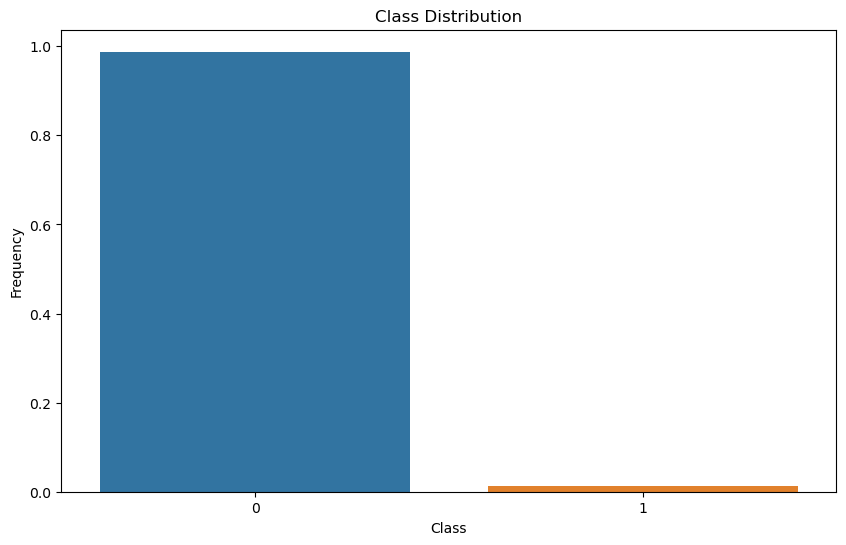

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [14]:
#Create a dictionary with precision, recall and f1 score
report = classification_report(y_val, y_pred_adjusted, output_dict=True)

In [15]:
#Convert dictionary to DataFrame
report_df = pd.DataFrame(report).transpose()

In [16]:
report_df 

,precision,recall,f1-score,support
0,0.999399,0.999807,0.999603,46583.000000
1,0.983813,0.951304,0.967286,575.000000
accuracy,0.999215,0.999215,0.999215,0.999215
macro avg,0.991606,0.975556,0.983444,47158.000000
weighted avg,0.999209,0.999215,0.999209,47158.000000


In [ ]:
#threshold adjustment to 0.6
#precision	recall	f1-score	support
#0	0.999399	0.999807	0.999603	46583.000000
#1	0.983813	0.951304	0.967286	575.000000
#accuracy	0.999215	0.999215	0.999215	0.999215
#macro avg	0.991606	0.975556	0.983444	47158.000000
#weighted avg	0.999209	0.999215	0.999209	47158.000000

#threshold adjustment to 0.4 and random trees 200
#precision	recall	f1-score	support
#0	0.999592	0.999764	0.999678	46583.000000
#1	0.980600	0.966957	0.973730	575.000000
#accuracy	0.999364	0.999364	0.999364	0.999364
#macro avg	0.990096	0.983360	0.986704	47158.000000
#weighted avg	0.999361	0.999364	0.999362	47158.000000

#SMOTE NORMALISE AMOUNT AND BALANCE CLASS WEIGHT, but 200 trees
#TOO SMALL A DIFFERENCE TO MATTER

#SMOTE NORMALISE AMOUNT AND BALANCE CLASS WEIGHT, but 100 trees

#precision	recall	f1-score	support
#0	0.999571	0.999764	0.999667	46583.000000
#1	0.980565	0.965217	0.972831	575.000000
#accuracy	0.999343	0.999343	0.999343	0.999343
#macro avg	0.990068	0.982491	0.986249	47158.000000
#weighted avg	0.999339	0.999343	0.999340	47158.000000

In [ ]:
#GBC results:

#Confusion Matrix:
#[[46083   414]
# [  963 45706]]

#Classification Report:

              #precision    recall  f1-score   support

           #0       0.98      0.99      0.99     46497
           #9       0.99      0.98      0.99     46669

In [18]:
# For the validation set: Save features, actual classes, and predictions
validation_results = X_val.copy()
validation_results['ActualClass'] = y_val
validation_results['PredictedClass'] = y_pred_adjusted

# Save the validation results to a CSV file
validation_results.to_csv('RFvalidation_results.csv', index=False)

training_results = X_train.copy()
training_results['ActualClass'] = y_train


training_results.to_csv('RFtraining_results.csv', index=False)


In [ ]:
prediction_data_path = 'sprint3_predictions.csv'
predict_df = pd.read_csv(prediction_data_path)

#Save the 'competition_id' column if it's going to be dropped during processing
if 'competition_id' in predict_df.columns:
    competition_id = predict_df['competition_id'].copy()

#Drop unwanted columns for prediction
predict_df.drop(columns=['competition_id', 'Predicted_class'], errors='ignore', inplace=True)

if 'Amount' in predict_df.columns:
    predict_df['NormalizedAmount'] = scaler.transform(predict_df[['Amount']])
    predict_df.drop(columns=['Amount'], inplace=True)

#Predict the classes using the trained model
y_pred = rf_classifier.predict(predict_df)

#Create a new DataFrame for the output to include 'competition_id' and 'predictions'
output_df = pd.DataFrame({
    'competition_id': competition_id,
    'Predicted_class': y_pred_adjusted
})

#Save the Dataframe 
#output_csv_path = '2RF_predictions_with_classes.csv'
#output_df.to_csv(output_csv_path, index=False)

In [ ]:
outputfd